# Test Technique Wiremind

## 1 - Analyse des données

Dans cette première partie, nous allons explorer les données fournies dans le fichier `cayzn_train.parquet`. Nous allons examiner la structure des données, vérifier l'intégrité des données, analyser les distributions des variables et visualiser les relations entre les variables.

In [ ]:
%pip install seaborn
%pip install fastparquet

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 1.1 Chargement et vérification de l'intégrité données

Dans un premier temps, nous allons charger le fichier de données et examiner les premières lignes pour comprendre la structure des données. Ensuite, nous allons vérifier les valeurs manquantes et la cohérence des dates.

#### Chargement des données

In [53]:
# Charger le fichier train
df = pd.read_parquet("../data/cayzn_train.parquet")

# Aperçu des premières lignes et des types de données
print("Aperçu des données :")
print(df.head())
print("\nTypes de données :")
print(df.info())


Aperçu des données :
   demand departure_date  destination_current_public_holiday  \
0       1     2019-03-01                                   0   
1       6     2019-03-01                                   0   
2       5     2019-03-01                                   0   
3       0     2019-03-01                                   0   
4       0     2019-03-01                                   0   

   destination_current_school_holiday  \
0                                   1   
1                                   1   
2                                   1   
3                                   1   
4                                   1   

   destination_days_to_next_public_holiday  \
0                                       52   
1                                       52   
2                                       52   
3                                       52   
4                                       52   

   destination_days_to_next_school_holiday destination_station_name  \

#### Vérification des dates et des valeurs manquantes

In [91]:
# Vérifier les valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())

# Vérifier la cohérence entre les dates
df['calculated_sale_date'] = pd.to_datetime(df['departure_date']) + pd.to_timedelta(df['sale_day_x'], unit='D')
inconsistent_dates = df[df['sale_date'] != df['calculated_sale_date']]

print(f"Nombre d'incohérences de date : {len(inconsistent_dates)}")
if not inconsistent_dates.empty:
    print(inconsistent_dates[['sale_date', 'calculated_sale_date', 'departure_date', 'sale_day_x']].head())



Valeurs manquantes :
demand                                     0
departure_date                             0
destination_current_public_holiday         0
destination_current_school_holiday         0
destination_days_to_next_public_holiday    0
destination_days_to_next_school_holiday    0
destination_station_name                   0
od_destination_time                        0
od_number_of_similar_12_hours              0
od_number_of_similar_2_hours               0
od_number_of_similar_4_hours               0
od_origin_month                            0
od_origin_time                             0
od_origin_week                             0
od_origin_weekday                          0
od_origin_year                             0
od_travel_time_minutes                     0
origin_current_public_holiday              0
origin_current_school_holiday              0
origin_days_to_next_public_holiday         0
origin_days_to_next_school_holiday         0
origin_station_name              

#### Détection des outliers

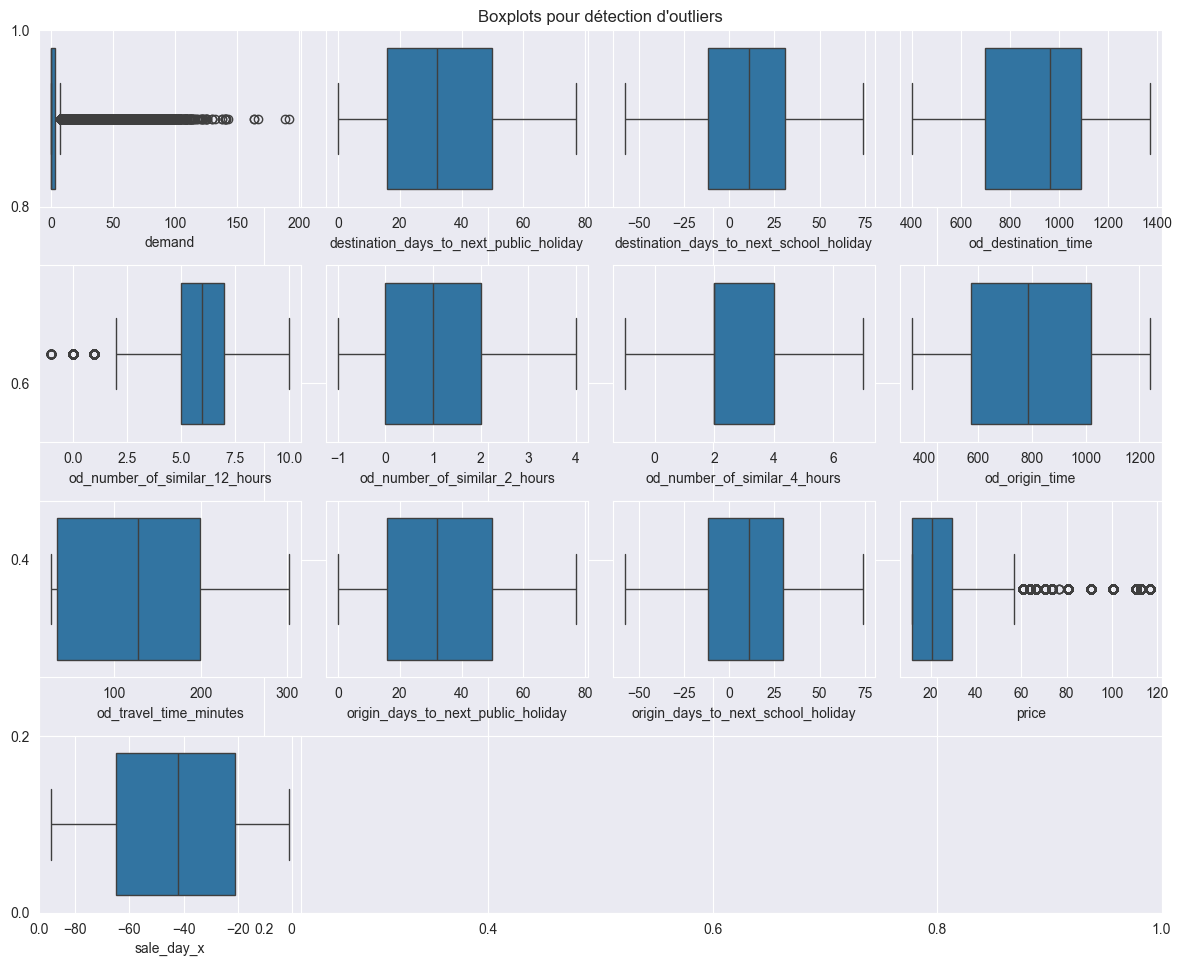

In [92]:
# Boîtes à moustaches pour détecter les outliers
numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns

# Supprimer les colonnes non pertinentes pour la visualisation
numerical_cols = numerical_cols.drop(["origin_current_public_holiday", "origin_current_school_holiday", "destination_current_public_holiday", "destination_current_school_holiday", "od_origin_weekday", "od_origin_week", "od_origin_month", "od_origin_year", "sale_day", "sale_month", "sale_year", "sale_week", "sale_weekday"])

plt.figure(figsize=(12, 10))
plt.title("Boxplots pour détection d'outliers")
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(data=df, x=col)
plt.tight_layout()
plt.show()
    

Il n'y a à priori pas de valeurs manquantes/aberrantes. Les seul outliers potentiels seraient des valeurs de la colonne "prix", cependant nous ne sommes pas en mesure de déterminer ce qui serait réellemnent un prix incohérent, et cela sort du cadre de ce test. Le même raisonnement s'applique à la colonne cible "demand".

### 1.2 Distribution des variables numériques clés

Maintenant nous allons nous intéresser à la distribution des variables numériques et catégorielles. Nous allons examiner la distribution de la demande, du prix, du temps de trajet et d'autres variables pertinentes, déterminées grâce à la matrice de corrélation.

#### Matrice de corrélation des variables numériques

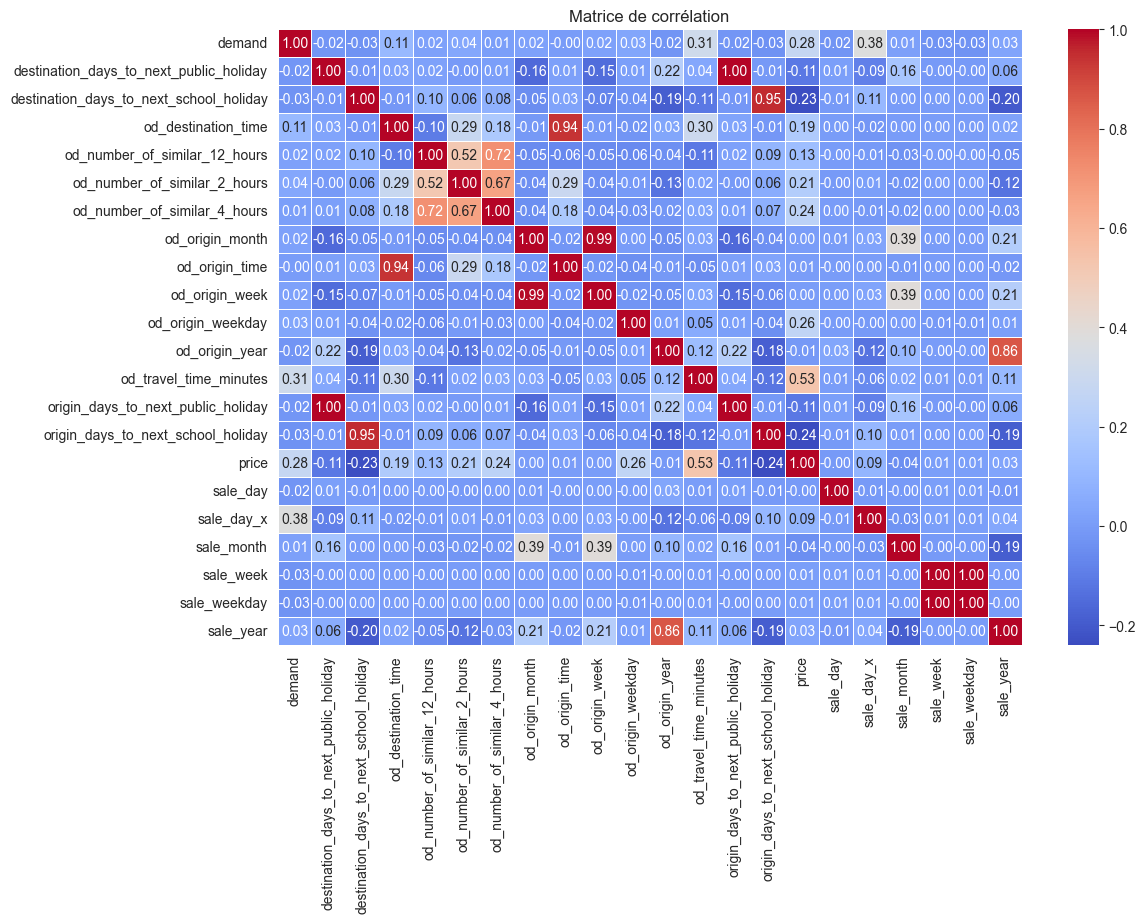

In [94]:
# Calculer la matrice de corrélation
corr_matrix_columns = df.select_dtypes(include=["float64", "int64"]).columns
corr_matrix_subset = df[corr_matrix_columns].drop(columns=["origin_current_public_holiday", "origin_current_school_holiday", "destination_current_public_holiday", "destination_current_school_holiday"])
correlation_matrix = corr_matrix_subset.corr()

# Heatmap de la corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Matrice de corrélation")
plt.show()


#### Visualisation des variables numériques clés en fonction de la demande

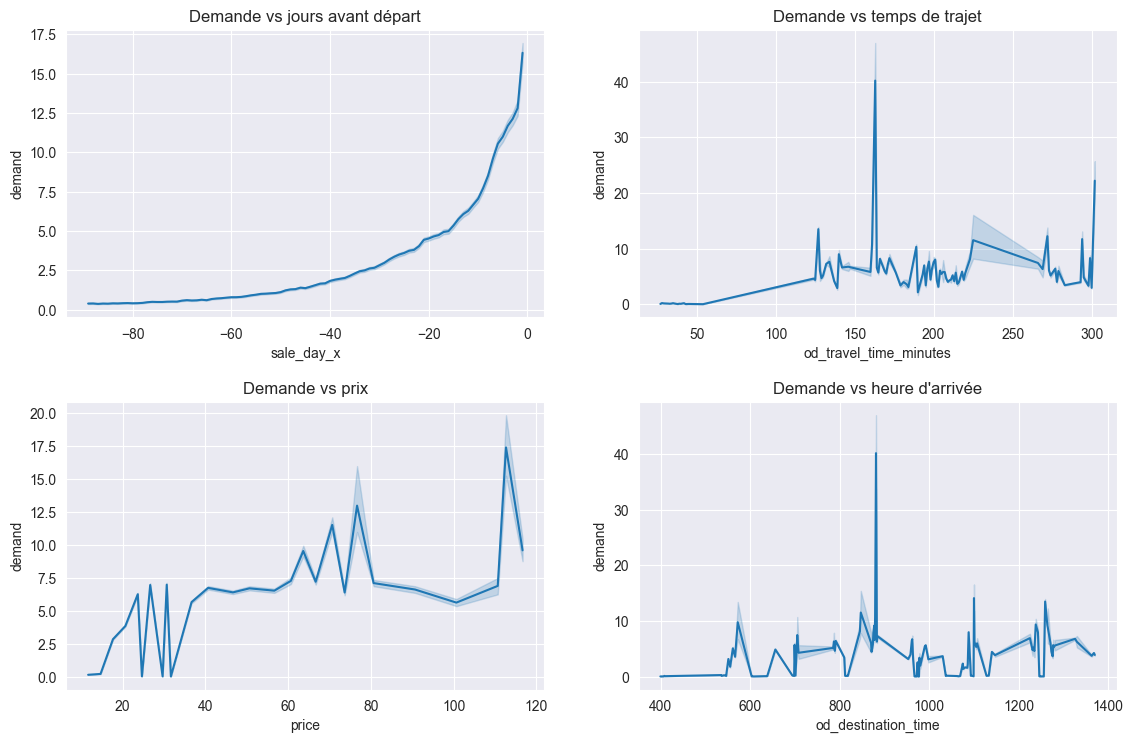

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=4.0)

# 1. Demande en fonction des jours avant départ
sns.lineplot(ax=axes[0, 0], data=df, x="sale_day_x", y="demand")
axes[0, 0].set_title("Demande vs jours avant départ")

# 2. Demande en fonction du temps de trajet
sns.lineplot(ax=axes[0, 1], data=df, x="od_travel_time_minutes", y="demand")
axes[0, 1].set_title("Demande vs temps de trajet")

# 3. Demande en fonction du prix
sns.lineplot(ax=axes[1, 0], data=df, x="price", y="demand")
axes[1, 0].set_title("Demande vs prix")

# 4. Demande en fonction de l'heure d'arrivée
sns.lineplot(ax=axes[1, 1], data=df, x="od_destination_time", y="demand")
axes[1, 1].set_title("Demande vs heure d'arrivée")

plt.show()


### 1.3 Distribution des variables catégorielles 


#### Distribution des ventes selon les jours, semaines, mois et années

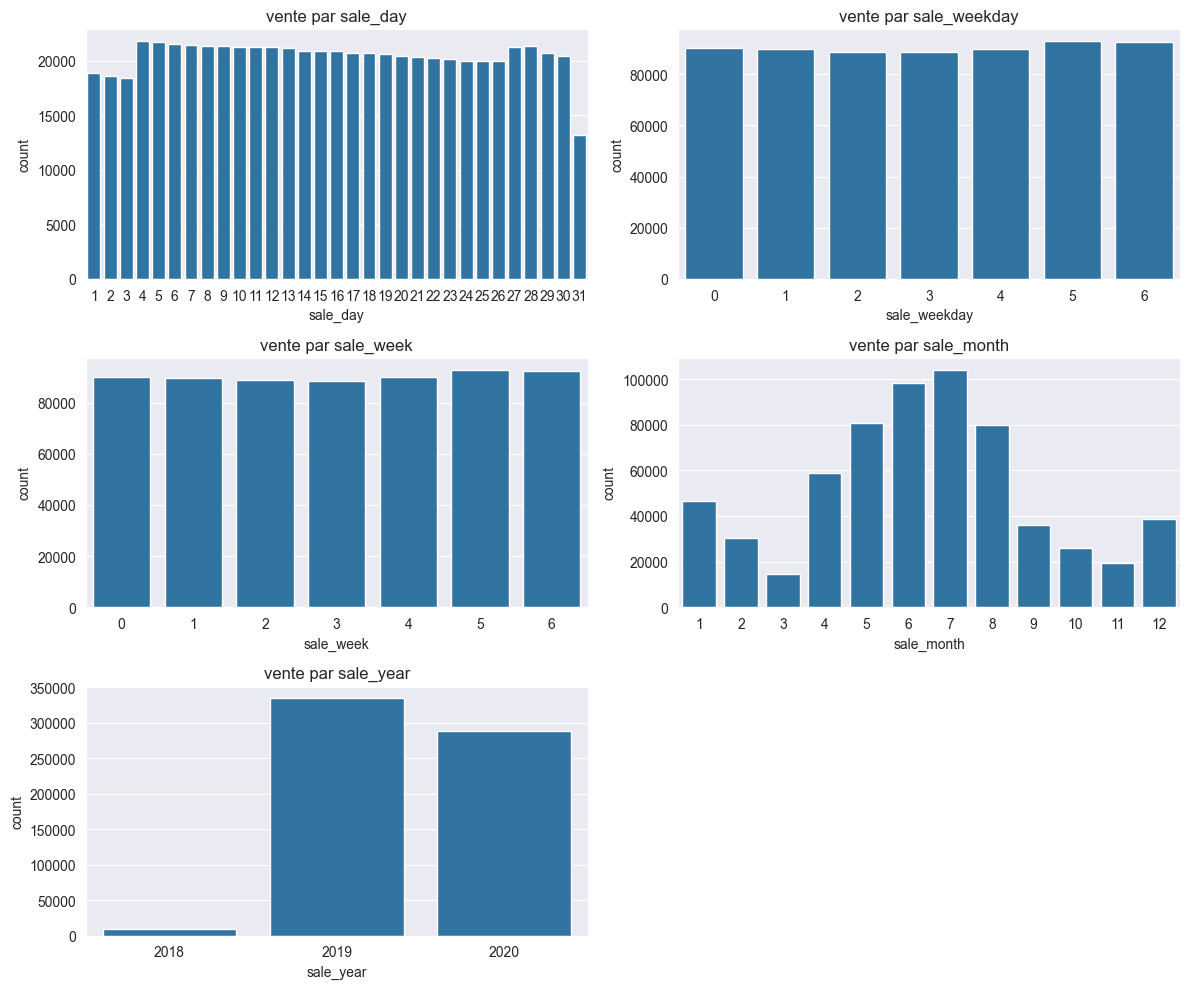

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des colonnes et des titres des graphiques
sale_infos_cols = ["sale_day", "sale_weekday","sale_week", "sale_month", "sale_year"]

# Création des graphiques dans une seule figure
plt.figure(figsize=(12, 10))

for i, col in enumerate(sale_infos_cols):
    plt.subplot(3, 2, i + 1)  # Ajustement pour avoir 3 lignes et 2 colonnes
    sns.countplot(data=df, x=col)
    plt.title(f"vente par {col}")

# Ajustement de la mise en page pour éviter le chevauchement
plt.tight_layout()
plt.show()


#### Repartition de la demande selon les jours de la semaine, mois et années

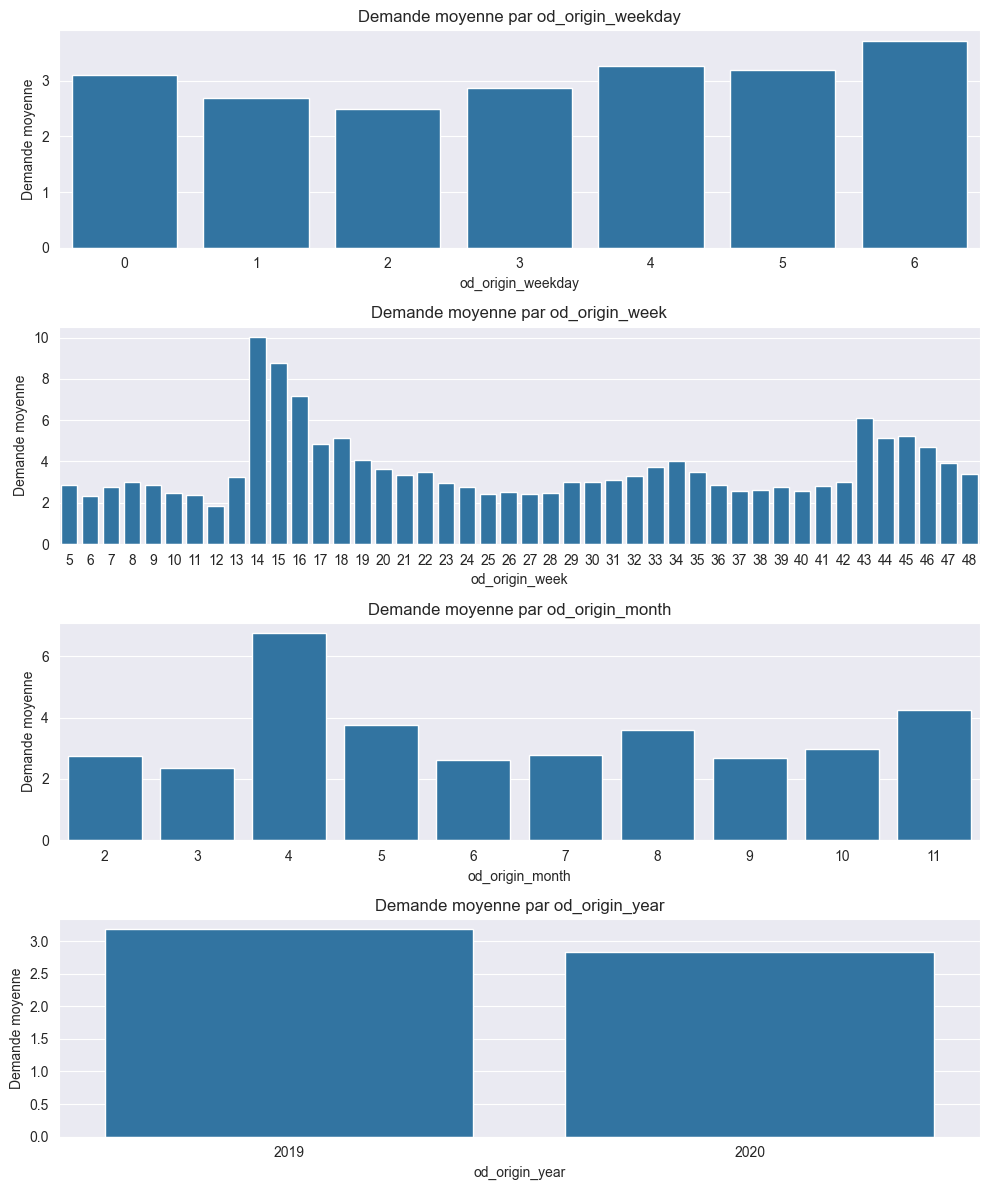

In [108]:

# Liste des colonnes temporelles
time_cols = ["od_origin_weekday", "od_origin_week", "od_origin_month", "od_origin_year"]

# Création des subplots
plt.figure(figsize=(10, 12))

for i, col in enumerate(time_cols):
    plt.subplot(4, 1, i + 1)
    avg_demand = df.groupby(col)["demand"].mean().reset_index()
    sns.barplot(data=avg_demand, x=col, y="demand")
    plt.title(f"Demande moyenne par {col}")
    plt.ylabel("Demande moyenne")
    plt.xlabel(col)

plt.tight_layout()
plt.show()


#### Analyse des caractéristiques sur trains uniques

Pour certaines statistiques, il est pertinent de ne garder qu'une ligne par train unique pour ne pas fausser les résultats.

In [54]:
# Créer une colonne identifiant chaque train unique
df['train_id'] = df['departure_date'].astype(str) + "_" + df['od_origin_time'].astype(str) + "_" + \
                 df['origin_station_name'] + "_" + df['destination_station_name']

# Filtrer pour ne garder qu'une ligne par train unique
unique_trains = df.drop_duplicates(subset=['train_id'])
print("Nombre de trains uniques :", unique_trains.shape[0])
"""print(unique_trains.head())"""


Nombre de trains uniques : 9173


'print(unique_trains.head())'

#### Proportion des trajets selon les vacances et jours fériés

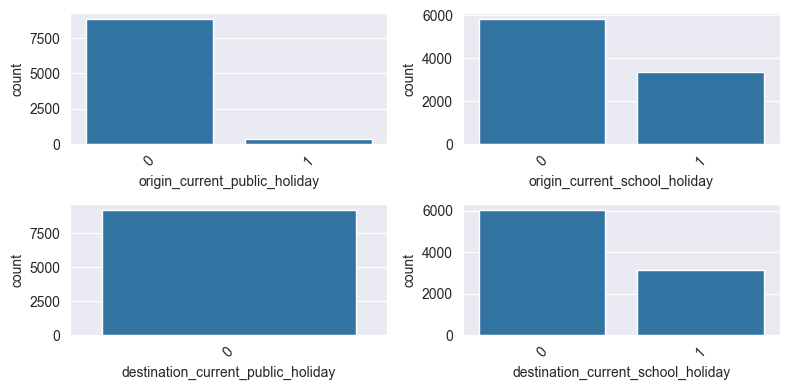

In [141]:
# Distribution des stations d'origine et de destination
holiday_cols = ["origin_current_public_holiday", "origin_current_school_holiday", "destination_current_public_holiday", "destination_current_school_holiday"]
# Extraire les colonnes catégorielles du DataFrame

plt.figure(figsize=(8, 4))
for i, col in enumerate(holiday_cols):
    plt.subplot(2, 2, i + 1)
    sns.countplot(data=unique_trains, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Répartition des origines et des destinations

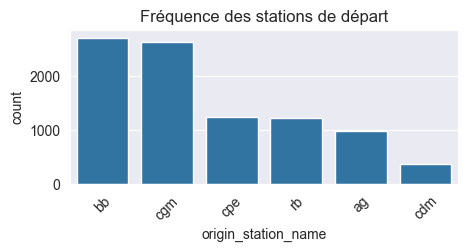

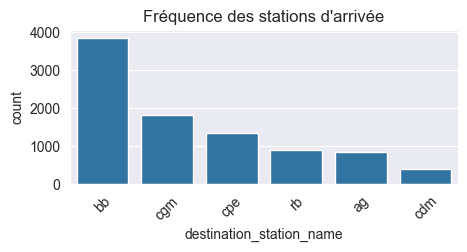

In [87]:
# Répartition des origines et destinations
plt.figure(figsize=(5, 2))
sns.countplot(data=unique_trains, x='origin_station_name', order=unique_trains['origin_station_name'].value_counts().index)
plt.title("Fréquence des stations de départ")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 2))
sns.countplot(data=unique_trains, x='destination_station_name', order=unique_trains['destination_station_name'].value_counts().index)
plt.title("Fréquence des stations d'arrivée")
plt.xticks(rotation=45)
plt.show()


#### Repartition des temps de trajet

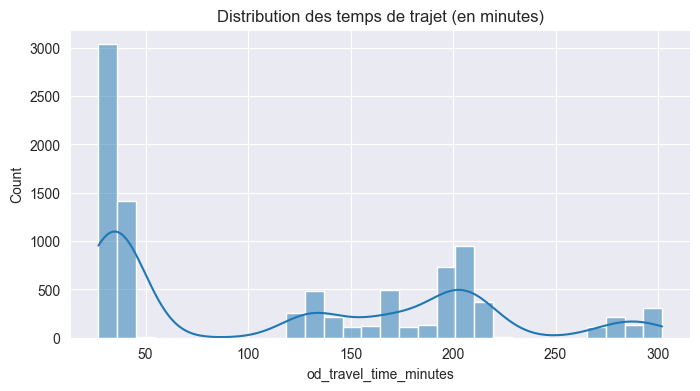

  origin_station_name destination_station_name  od_travel_time_minutes
0                  ag                      cpe              144.237563
1                  bb                      cgm               33.993939
2                  bb                       rb              210.878319
3                 cdm                      cpe              289.587601
4                 cgm                       bb               35.619681


In [143]:
plt.figure(figsize=(8, 4))
sns.histplot(data=unique_trains, x='od_travel_time_minutes', bins=30, kde=True)
plt.title("Distribution des temps de trajet (en minutes)")
plt.show()

# Temps de trajet moyen par trajet
avg_travel_time = unique_trains.groupby(['origin_station_name', 'destination_station_name'])['od_travel_time_minutes'].mean().reset_index()
print(avg_travel_time.head())


### 1.4 Statistiques plus avancées

#### Demande en fonction des vacancaes et jours fériés

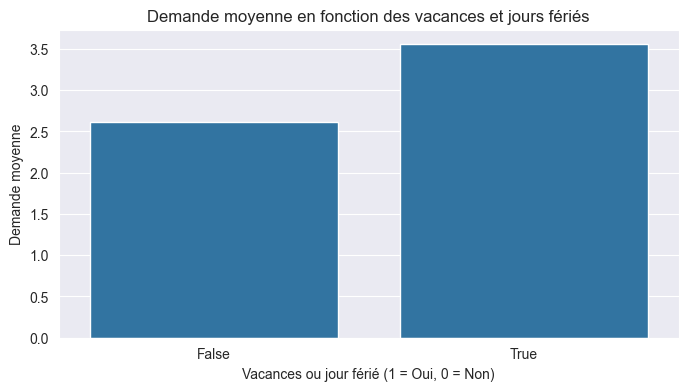

In [111]:
# Création d'une nouvelle colonne indiquant si c'est un jour férié ou de vacances (origine ou destination)
df['is_holiday'] = (
    (df['origin_current_public_holiday'] == 1) |
    (df['origin_current_school_holiday'] == 1) |
    (df['destination_current_public_holiday'] == 1) |
    (df['destination_current_school_holiday'] == 1)
)

# Agrégation de la demande moyenne en fonction des jours fériés et vacances
holiday_demand = df.groupby('is_holiday')['demand'].mean().reset_index()

# Visualisation
plt.figure(figsize=(8, 4))
sns.barplot(data=holiday_demand, x='is_holiday', y='demand')
plt.title("Demande moyenne en fonction des vacances et jours fériés")
plt.xlabel("Vacances ou jour férié (1 = Oui, 0 = Non)")
plt.ylabel("Demande moyenne")
plt.show()


#### Demande en fonction de l'approche des vacances

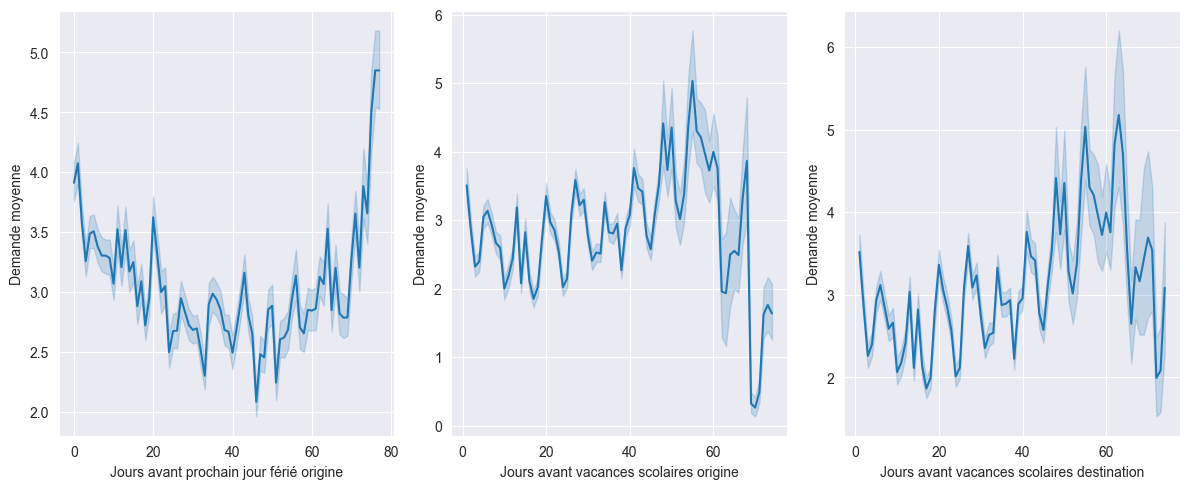

In [144]:
# Configuration de l'affichage
plt.figure(figsize=(12, 5))

# Plot 1 : Jours avant prochain jour férié à l'origine
plt.subplot(1, 3, 1)
sns.lineplot(
    data=df,
    x="origin_days_to_next_public_holiday",
    y="demand",
    estimator="mean"
)
plt.xlabel("Jours avant prochain jour férié origine")
plt.ylabel("Demande moyenne")

# Plot 2 : Jours avant prochaines vacances scolaires à l'origine
plt.subplot(1, 3, 2)
sns.lineplot(
    x=df[df["origin_days_to_next_school_holiday"] > 0]["origin_days_to_next_school_holiday"],
    y=df[df["origin_days_to_next_school_holiday"] > 0]["demand"],
    estimator="mean"
)
plt.xlabel("Jours avant vacances scolaires origine")
plt.ylabel("Demande moyenne")

# plot 3 : jours avant les vacances scolaire à la destination
plt.subplot(1, 3, 3)
sns.lineplot(
    x=df[df["destination_days_to_next_school_holiday"] > 0]["destination_days_to_next_school_holiday"],
    y=df[df["destination_days_to_next_school_holiday"] > 0]["demand"],
    estimator="mean"
)
plt.xlabel("Jours avant vacances scolaires destination")
plt.ylabel("Demande moyenne")


plt.tight_layout()
plt.show()


#### Distribution des trajets trains similaires par train unique

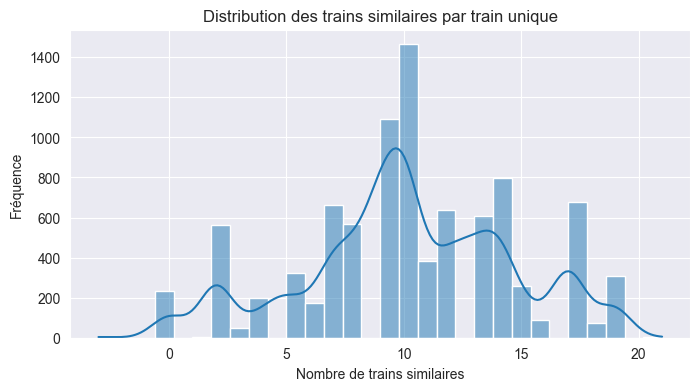

In [135]:
unique_trains.loc[:,"total_similar_trains"] = unique_trains["od_number_of_similar_2_hours"] + unique_trains["od_number_of_similar_4_hours"] + unique_trains["od_number_of_similar_12_hours"]
# Lineplot pour voir la distribution
plt.figure(figsize=(8, 4))
sns.histplot(data=unique_trains, x='total_similar_trains', bins=30, kde=True)
plt.title("Distribution des trains similaires par train unique")
plt.xlabel("Nombre de trains similaires")
plt.ylabel("Fréquence")
plt.show()

#### Demande moyenne par itinéraire

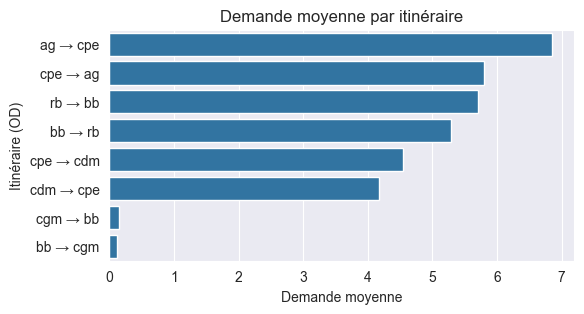

In [104]:
# Créer une colonne représentant l'itinéraire (OD) sous forme de chaîne
df['od_route'] = df['origin_station_name'] + ' → ' + df['destination_station_name']

# Calculer la demande moyenne par itinéraire
od_demand = df.groupby('od_route')['demand'].mean().reset_index()

# Trier les itinéraires par demande décroissante pour améliorer la lisibilité
od_demand = od_demand.sort_values(by='demand', ascending=False)

# Visualisation
plt.figure(figsize=(6, 3))
sns.barplot(data=od_demand, x='demand', y='od_route')
plt.title("Demande moyenne par itinéraire")
plt.xlabel("Demande moyenne")
plt.ylabel("Itinéraire (OD)")
plt.show()

# Conclusion / conjecture

L’analyse exploratoire a mis en évidence plusieurs facteurs fortement liés à la demande. Comme on pouvait s’y attendre, celle-ci est particulièrement sensible au prix, au nombre de jours restants avant le départ, ainsi qu’au temps de trajet. L’heure d’arrivée semble également jouer un rôle, bien que dans une moindre mesure.

D’un point de vue temporel, certaines variables présentent de fortes redondances. C’est le cas notamment des heures de départ et d’arrivée, qui sont naturellement corrélées. Cela ouvre la voie à une simplification du jeu de données, en supprimant ou en fusionnant des variables fortement liées.

La demande augmente clairement pendant les vacances scolaires et les jours fériés, mais aussi dans les jours qui précèdent ces périodes. Ces constats justifient la création de nouvelles variables comme une "indicateur haute saison" ou une "proximité avec vacances", qui pourraient enrichir les modèles prédictifs.

Certaines stations et itinéraires sont nettement plus demandés que d’autres. Il serait donc pertinent d’introduire une variable décrivant l’itinéraire (par exemple sous forme d’une concaténation origine-destination) afin de capter ces effets spécifiques.

Par ailleurs, les données révèlent que les vacances scolaires sont toujours synchrones entre les gares de départ et d’arrivée, ce qui rend inutile le maintien des deux colonnes. De plus, aucune destination ne semble concernée par un jour férié, ce qui permet de supprimer également cette variable.

Enfin on  remarqué un grande disparité dans la répartition des temps de trajets, or cette variable est relativement corrélé avec la demande, il aura également pu être intéressant de partitionner cette dernière en différentes catégories "long", "court", "moyen"...

Les relations non linéaires entre les principales variables explicatives et la demande, ainsi que la nature tabulaire des données, indiquent que des modèles comme ceux basés sur le boosting (XGBoost, LightGBM) pourraient être particulièrement efficaces. Des techniques complémentaires de réduction de dimension ou de sélection de variables (comme l’ACP ou les forêts aléatoires) pourraient également être envisagées pour améliorer les performances et la lisibilité du modèle.




## 2 - Model Training

 Dans cette partie nous allons donc procéder à la sélection/création de feature suggérées dans la partie précédente. Ensuite, nous allons créer une pipeline de prétraitement et d’entraînement du modèle. Le prétritement contiendra l'encodage des variables catégorielles restantes, ainsi que la standardisation des variables numériques. Nous allons utiliser LightGBM pour l'entraînement du modèle, car il est particulièrement adapté aux données tabulaires et peut gérer de grandes quantités de données efficacement. 
Nous allons également effectuer une validation croisée pour évaluer les performances du modèle.

In [ ]:
%pip install scikit-learn

In [ ]:
%pip install xgboost

In [ ]:
%pip install lightgbm

In [2]:
import sklearn
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

### 2.1 Feature selection and engineering

#### Feature selection

In [3]:
train_data = pd.read_parquet('../data/cayzn_train.parquet')
#Selection des variables
# Comme dejà encodé, on ne vas pas utiliser ces features
train_data = train_data.drop(columns=["sale_date", "departure_date"])
# On pourra éventuellement laissé de côté "destination_public_holiday" car constamment == 0
train_data = train_data.drop(columns=["destination_current_public_holiday"])

#### Feature engineering

In [4]:
# Création d'une variable "haute saison" : mois avec forte demande (mai, juin, septembre, décembre)
train_data['haute_saison'] = train_data['sale_day_x'].apply(lambda x: 1 if x in [4, 5, 8, 11] else 0)

# Indicateur de proximité avec un jour férié : moins de 10 jours
train_data['is_public_holiday_near'] = train_data["origin_days_to_next_public_holiday"] <= 10

# Regrouper les trains similaires dans une seule variable
train_data['total_similar_trains'] = (
    train_data['od_number_of_similar_2_hours'] +
    train_data['od_number_of_similar_4_hours'] +
    train_data['od_number_of_similar_12_hours']
)

# Création de catégories de densité d'itinéraires
train_data['od_similar_low_density'] = train_data['total_similar_trains'] <= 8
train_data['od_similar_medium_density'] = train_data['total_similar_trains'].between(8, 12, inclusive="right")
# Pas de variable 'high density' pour éviter la colinéarité

# Indicateur de vacances scolaires à la fois à l'origine et à la destination
train_data['is_school_holiday'] = (
    (train_data['origin_current_school_holiday'] == 1) & 
    (train_data['destination_current_school_holiday'] == 1)
)

# Suppression des anciennes variables de vacances scolaires
train_data.drop(columns=['origin_current_school_holiday', 'destination_current_school_holiday'], inplace=True)

# Création de la variable d'itinéraire : origine → destination
train_data['od_route'] = train_data['origin_station_name'] + ' → ' + train_data['destination_station_name']


### 2.2 Création de la Pipeline

In [41]:
# On encode uniquement les stations, car les date sont déjà encodés

# Creation de la pipeline
stationColumns = ['origin_station_name', 'destination_station_name']
allStations = pd.concat([train_data[stationColumns[0]], train_data[stationColumns[1]]])
stationEncoder = (sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(pd.DataFrame(allStations)))
itinaryEncoder = (sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(pd.DataFrame(train_data['od_route'])))

itinary_mapping = dict(zip(itinaryEncoder.categories_[0], range(len(itinaryEncoder.categories_[0]))))

numericalColumns = train_data.drop(columns=["demand"]).select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = sklearn.compose.ColumnTransformer(
    transformers = [
        ('originEncoder', stationEncoder, [stationColumns[0]]),
        ('destinationEncoder', stationEncoder, [stationColumns[1]]),
        ('itinaryEncoder', itinaryEncoder, ['od_route']),
        ('standardscaler', sklearn.preprocessing.StandardScaler(), numericalColumns)
    ],
    remainder="passthrough"
)

LightGBMpipeline = sklearn.pipeline.Pipeline( ## pertinent pour sa capacité à gérer les données données en très gros volumes, pas nécessaire de faire de la réduction de dimension car déjà le but de l'algo
    steps= [
        ('preprocessing', preprocessor),
        ('regressor', LGBMRegressor(random_state=0, objective="regression", metric="rmse", n_jobs=-1))
    ]
)

Remarque : Ici on observe la pipeline finale retenue, ayant montrée les meilleurs résulats. Parims les modèles essayés, on retrouve le RandomForestRegressor, XGBoostRegressor ou encore CatBoostRegressor, qui sont tous des algorithmes de boosting adaptés aux données tabulaires. On a de plus tester des modèles de regression traditionnels (Ridge, Lasso) mais aussi une sélection de variables à l'aide du facteur "Importance" du RFR, et du XGBoost, sans que cela n'améliore les performances.

### 2.3 Entrainement du modèle

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y = train_data.demand
X = train_data.drop(columns=["demand"])

## TODO hyperparameters tuning

lgbm_search = GridSearchCV(LightGBMpipeline, {},  cv=10, n_jobs=-1, verbose=1)

# Fit on your data (replace df and target column as needed)

lgbm_search.fit(X, y)

print("LightGBM best score:", lgbm_search.best_score_) #Return the coefficient of determination of the prediction.


print("LightGBM best params:", lgbm_search.best_params_)



Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1096
[LightGBM] [Info] Number of data points in the train set: 632841, number of used features: 47
[LightGBM] [Info] Start training from score 3.000149
LightGBM best score: 0.750381616416935
LightGBM best params: {}


In [48]:
import numpy as np

def evaluate_overall(y_true, y_pred, price=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.where(y_true == 0, 0, np.abs((y_true - y_pred) / y_true))) * 100


    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
print("Evaluation globale sur le jeu de données d'entrainement")
evaluate_overall(y, lgbm_search.predict(X))

Evaluation globale sur le jeu de données d'entrainement


C:\Users\jules\PycharmProjects\wiremind_2\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RMSE: 3.24
MAE: 1.48
MAPE: 25.30%


## 3 - Model validation

3.1 Application du processus complet à la donnée de test

In [49]:
## prediction on the test value
test_data = pd.read_parquet('../data/cayzn_test.parquet')
test_sale_dates = test_data['sale_date'].values

# Création d'une variable "haute saison" : mois avec forte demande (mai, juin, septembre, décembre)
test_data['haute_saison'] = test_data['sale_day_x'].apply(lambda x: 1 if x in [4, 5, 8, 11] else 0)

# Indicateur de proximité avec un jour férié : moins de 10 jours
test_data['is_public_holiday_near'] = test_data["origin_days_to_next_public_holiday"] <= 10

# Regrouper les trains similaires dans une seule variable
test_data['total_similar_trains'] = (
    test_data['od_number_of_similar_2_hours'] +
    test_data['od_number_of_similar_4_hours'] +
    test_data['od_number_of_similar_12_hours']
)

# Création de catégories de densité d'itinéraires
test_data['od_similar_low_density'] = test_data['total_similar_trains'] <= 8
test_data['od_similar_medium_density'] = test_data['total_similar_trains'].between(8, 12, inclusive="right")
# Pas de variable 'high density' pour éviter la colinéarité

# Indicateur de vacances scolaires à la fois à l'origine et à la destination
test_data['is_school_holiday'] = (
    (test_data['origin_current_school_holiday'] == 1) & 
    (test_data['destination_current_school_holiday'] == 1)
)

# Suppression des anciennes variables de vacances scolaires
test_data.drop(columns=['origin_current_school_holiday', 'destination_current_school_holiday'], inplace=True)

# Création de la variable d'itinéraire : origine → destination
test_data['od_route'] = test_data['origin_station_name'] + ' → ' + test_data['destination_station_name']


X_test = test_data.drop(columns=["demand"])
y_test = test_data.demand

y_test_pred = lgbm_search.predict(X_test)
test_data['predicted_demand'] = y_test_pred

C:\Users\jules\PycharmProjects\wiremind_2\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### 3.2 Evaluation des performances

#### Evaluation globale

In [50]:
# Assuming 'y_true', 'y_pred' are arrays with actual and predicted demand
  
# Example:
print("Evaluation globale sur le jeu de données de test")
evaluate_overall(y_test, y_test_pred)


Evaluation globale sur le jeu de données de test
RMSE: 4.08
MAE: 1.80
MAPE: 26.49%


#### Evaluation sur différents types d'aggrégations

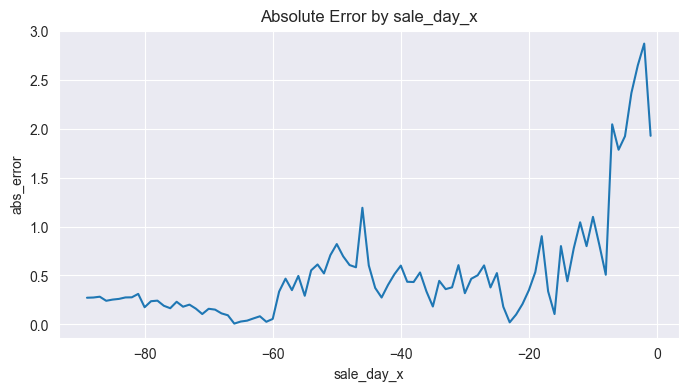

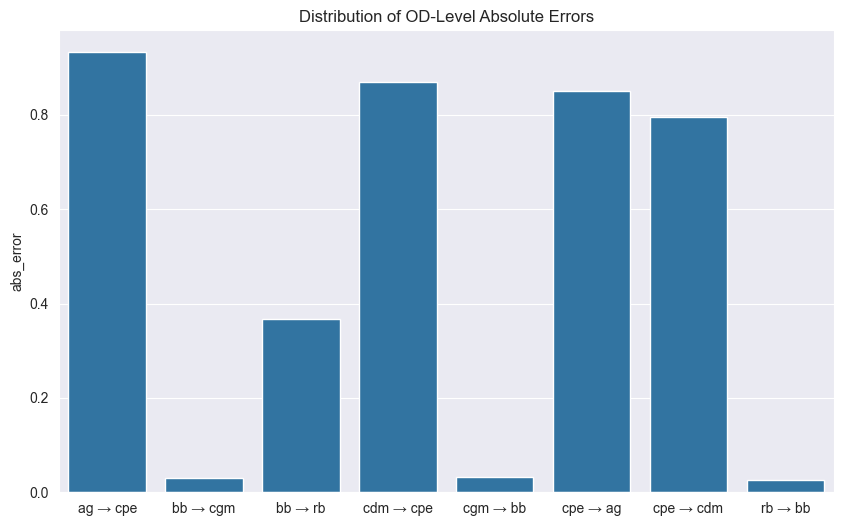

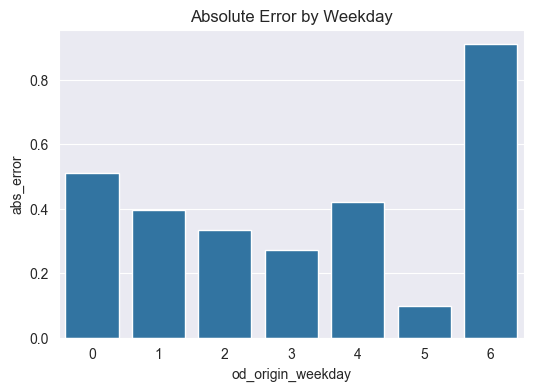

In [51]:
def aggregate_error(df, group_col, y_true='demand', y_pred='predicted_demand'): ## Metric is MAE
    agg = df.groupby(group_col).agg({
        y_true: 'mean',
        y_pred: 'mean'
    }).reset_index()
    
    agg['abs_error'] = np.abs(agg[y_true] - agg[y_pred])
    return agg


day_x_agg = aggregate_error(test_data, 'sale_day_x')

plt.figure(figsize=(8, 4))
sns.lineplot(data=day_x_agg, x='sale_day_x', y='abs_error')
plt.title("Absolute Error by sale_day_x")
plt.show()

od_agg = aggregate_error(test_data, ['od_route'])

plt.figure(figsize=(10, 6))
sns.barplot(x=itinary_mapping.keys(), y=od_agg['abs_error'])
plt.title("Distribution of OD-Level Absolute Errors")
plt.show()

weekday_agg = aggregate_error(test_data, 'od_origin_weekday')

plt.figure(figsize=(6, 4))
sns.barplot(data=weekday_agg, x='od_origin_weekday', y='abs_error')
plt.title("Absolute Error by Weekday")
plt.show()




### Erreur par rapport u sale_day_x :
L'erreur explose lorsque le nombre de jour avant le départ est faible. Cela peut être dû à une demande plus volatile à l'approche du départ, où les prix peuvent fluctuer davantage en fonction de la disponibilité et de la demande.
### Erreur par rapport à l'itinéraire :
Les itinéraires sur lesquels l'erreur est la plus importante sont ceux impliquant la station "ce", ce qui 
peut vouloir dire que la demande est plus volatile sur ces trajets. Il serait intéressant de creuser cette station pour voir si elle est plus sujette à des variations de prix ou de disponibilité. Cela suggère par exemple la création d'une feature 'High/Low demand itinary"...
### Erreur par rapport au jour de la semaine :
L'erreur est plus importante le week-end, ce qui, encore une fois, peut être dû à une demande plus volatile pendant ces jours-là. Cela pourrait être lié à des événements spéciaux ou à des vacances scolaires, que notre modèle  n'a pas arriver à prédire malgrès la création de nombreuses features allant dans ce sens

#### Evaluation par tranche de prix

C:\Users\jules\AppData\Local\Temp\ipykernel_434840\751737054.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(group_col).agg({


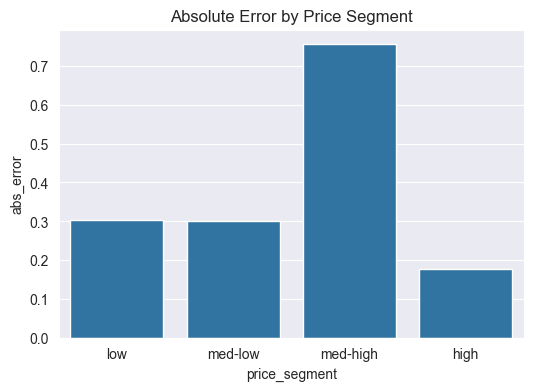

In [11]:
test_data['price_segment'] = pd.qcut(test_data['price'], q=4, labels=['low', 'med-low', 'med-high', 'high'])
price_agg = aggregate_error(test_data, 'price_segment')

plt.figure(figsize=(6, 4))
sns.barplot(data=price_agg, x='price_segment', y='abs_error')
plt.title("Absolute Error by Price Segment")
plt.show()


On observe que l'erreur absolue est nettement plus élevée pour le segment "med-high" (prix moyen-haut), atteignant environ 0.75, ce qui indique que le modèle a plus de difficultés à prédire correctement la demande pour ces tarifs.

À l'inverse, l'erreur est beaucoup plus faible pour le segment "high", et modérée pour les segments "low" et "med-low" (autour de 0.3).

Cela suggère que la relation entre le prix et la demande n'est pas linéaire et que le modèle a plus de mal à gérer des zones de prix intermédiaires élevés, où les comportements d'achat peuvent être plus hétérogènes (par exemple : certains clients fuient les prix élevés, d'autres achètent en urgence).

On aurait peut être pu se tourner vers des modèles GAM, performant dans la modélisation de relations non-linéaires complexes entre prédicteurs et variable cible.

#### Evaluation des résidus

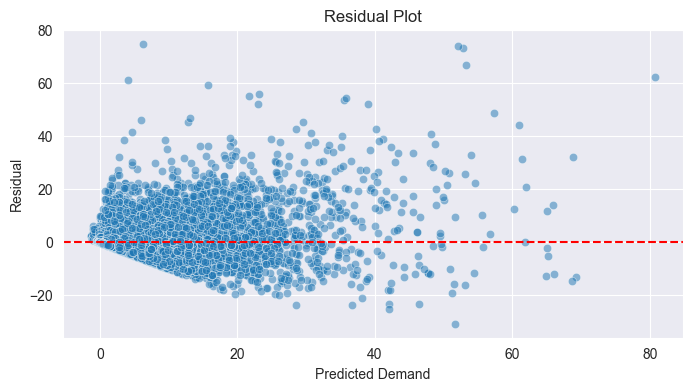

In [12]:
test_data['residual'] = test_data['demand'] - test_data['predicted_demand']

plt.figure(figsize=(8, 4))
sns.scatterplot(data=test_data, x='predicted_demand', y='residual', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Demand")
plt.ylabel("Residual")
plt.show()


### Interprétation :
On observe que les résidus sont globalement centrés autour de zéro, ce qui est une bonne chose, indiquant que le modèle n'est pas (ou ne semble pas) biaisé

Cependant, la dispersion est relativement élevé, et la variance des erreurs augmente fortement avec la demande.

Cela peut s'avérer problématique dans l'application concrète de l'algorithme, donnant en effet lieu à de la sur/sous réservation

#### Evaluation par rapport à la date de vente

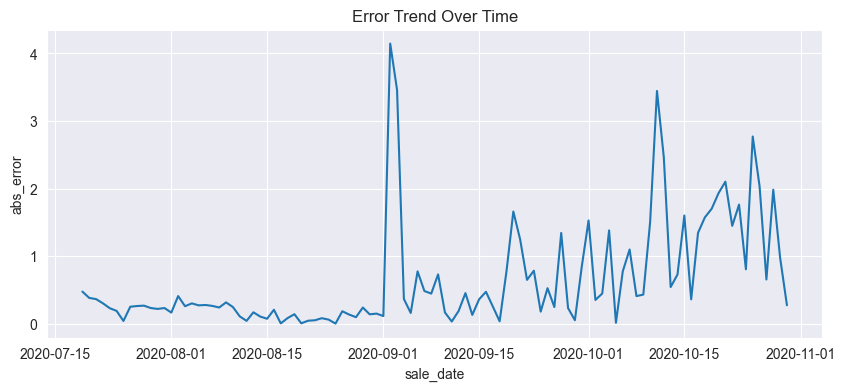

In [24]:
test_data['sale_date'] = pd.to_datetime(test_sale_dates)

time_agg = aggregate_error(test_data, 'sale_date')

plt.figure(figsize=(10, 4))
sns.lineplot(data=time_agg, x='sale_date', y='abs_error')
plt.title("Error Trend Over Time")
plt.show()


### Interprétation :

On oberserve sur ce graphique que les performances du modèles sont relativement stable pendant la période du confinement, ce qui peut s'expliquer par une utilisation plus modéré des services de transports que la normal, donnant lieu à des comportements plus prévisibles. En revanche, les performances sont bien plus hétérogènes à partir de la fin de l'été 2020, où le déconfinement battait son plein, mais aussi à l'approche de la seconde vague, ce qui peut s'expliquer par une demande plus volatile, et des comportements d'achat moins prévisibles.

### Evaluation par rapport au "revenu"

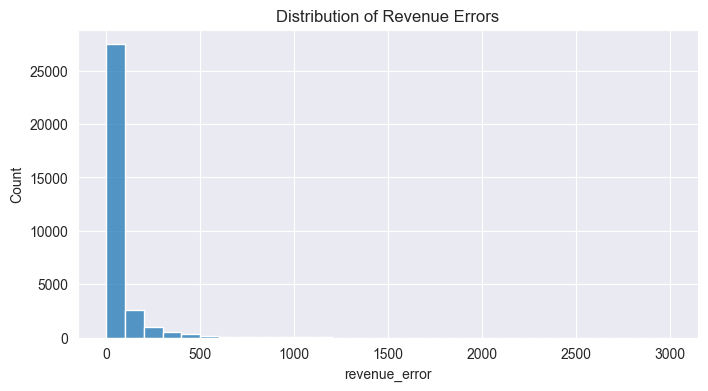

In [58]:
test_data['revenue'] = test_data['price'] * test_data['demand']
test_data['predicted_revenue'] = test_data['price'] * test_data['predicted_demand']
test_data['revenue_error'] = np.abs(test_data['revenue'] - test_data['predicted_revenue'])

plt.figure(figsize=(8, 4))
sns.histplot(test_data['revenue_error'], bins=30)
plt.title("Distribution of Revenue Errors")
plt.show()


Le graphique représente la distribution des erreurs de revenu, calculées comme la différence absolue entre le revenu réel (price × demand) et le revenu prédit (price × predicted_demand).

La distribution est très asymétrique et fortement concentrée autour de zéro, ce qui signifie que dans la majorité des cas, l’erreur de revenu est faible, ce qui apporte certaines certitudes sur l'aptidude du modèle à prédire la demande, et donc à optimiser le revenu. (si on peut prédire la demande, on peut maximiser les ventes)

Cependant, un nombre non négligeable de cas présentent des erreurs de revenu très élevées (entre 200 et 500€), ce qui peut être problématique d'un point de vue business. Ces erreurs peuvent entraîner des pertes de chiffre d'affaires importantes ou une mauvaise gestion de la capacité.

## 4 - Conclusion
Globalement, le modèle parvient à prédire la demande avec une bonne précision dans la majorité des cas, ce qui se reflète dans des erreurs de revenu souvent faibles.

Cependant, les grandes erreurs ponctuelles sont préoccupantes d’un point de vue business, car elles peuvent entraîner des pertes de chiffre d’affaires importantes ou une mauvaise gestion de la capacité.

Cela souligne deux points importants pour l'hypothétique suite du projet :

Optimiser la précision pour les cas à forte valeur (ex. : trajets chers ou à forte demande) est prioritaire, car les conséquences financières y sont plus lourdes.

Il serait pertinent d’intégrer les revenus dans la fonction de coût lors de l'entraînement du modèle, afin de mieux aligner la performance technique avec les objectifs économiques.